# Analyse Descriptive

In [44]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (8, 6)
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import scipy as sp
from urllib import request
import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

### Récupération des csv précédement nettoyer

In [45]:
produits = pd.read_csv("produits.csv")
clients = pd.read_csv("clients.csv")
ventes = pd.read_csv("ventes.csv")

### Analyse Descriptive

#### Ajustement Format Date

In [46]:
def first(string):
    parts = string.split(' ')
    first_part = parts[0]
    return first_part

ventes['date']=ventes['date'].apply(first)

In [47]:
ventes['date'] = ventes['date'].astype('datetime64[ns]')
ventes['jour'] = ventes.date.dt.day_name()

#### Création de la colonne 'JOUR' 

### Initiation MERGE price

In [48]:
price = produits[["id_prod","price"]]

In [49]:
ventes = pd.merge(ventes,price,left_on= "id_prod", right_on= "id_prod")

#### Merge Produits/Ventes sur "id_prod"

### Initiation MERGE sex

In [50]:
sex=clients[["sex","client_id"]]

In [51]:
ventes = pd.merge(ventes,sex,left_on="client_id", right_on="client_id")

#### Merge Clients/Ventes sur "client_id"

### Initiation MERGE age

In [52]:
clients["age"] = 2020 - clients.birth
age = clients[["age","client_id"]]

In [53]:
ventes = pd.merge(ventes,age,left_on="client_id", right_on="client_id")

#### Merge Clients/Ventes pour l'age sur "client_id"

### Ajout de la colonne "MOIS" 

In [54]:
ventes['mois'] = pd.DatetimeIndex(ventes['date']).month

In [55]:
ventes.head(5)

,client_id,id_prod,date,session_id,jour,price,sex,age,mois
0,c_5828,2_99,2021-11-21,s_122697,Sunday,84.99,f,22,11
1,c_5828,2_39,2022-01-22,s_153560,Saturday,57.99,f,22,1
2,c_5828,2_163,2021-07-07,s_59185,Wednesday,68.99,f,22,7
3,c_5828,2_141,2021-08-06,s_72146,Friday,158.99,f,22,8
4,c_5828,1_566,2022-01-06,s_145790,Thursday,16.95,f,22,1


#### Affichage des mois de 1 à 12 (janvier à decembre)

### Création d'une copy du DataFrame ventes

In [56]:
df = ventes.copy()

In [57]:
df.head(5)

,client_id,id_prod,date,session_id,jour,price,sex,age,mois
0,c_5828,2_99,2021-11-21,s_122697,Sunday,84.99,f,22,11
1,c_5828,2_39,2022-01-22,s_153560,Saturday,57.99,f,22,1
2,c_5828,2_163,2021-07-07,s_59185,Wednesday,68.99,f,22,7
3,c_5828,2_141,2021-08-06,s_72146,Friday,158.99,f,22,8
4,c_5828,1_566,2022-01-06,s_145790,Thursday,16.95,f,22,1


#### Permet de garder une sauvegarde de la DataFrame ventes de base

### Vérification des valeurs de "client_id"

In [58]:
df['client_id'].value_counts().head(10)
## c_1609  :  12855 / c_6714  :   4475 / c_3454  :   3277 / c_4958   :  2562

c_1609    12855
c_6714     4473
c_3454     3275
c_4958     2562
c_7959      195
c_2140      195
c_8026      193
c_2595      193
c_3725      190
c_8392      189
Name: client_id, dtype: int64

#### 4 client_id sont hors norme "outliers" 

### Calcul de la recette des outliers

In [59]:
list_outliers = ("c_1609", "12855" , "c_6714" , "c_3454",  "c_4958")

clients_outliers = df.loc[df["client_id"].isin(list_outliers)] 
print(clients_outliers.price.sum())
print((clients_outliers.price.sum())/(df.price.sum()))

433951.61
0.07484785472830238


#### La recette des outliers est de 434108.81 euros, ce qui représente 7% du CA

### Retrait des clients "outliers" de la DataFrame

In [60]:
df = df[~df.client_id.isin(list_outliers)]

In [61]:
df['client_id'].value_counts().head(10)

c_2140    195
c_7959    195
c_8026    193
c_2595    193
c_3725    190
c_7421    189
c_8392    189
c_3263    188
c_2077    188
c_5922    187
Name: client_id, dtype: int64

In [62]:
df

,client_id,id_prod,date,session_id,jour,price,sex,age,mois
0,c_5828,2_99,2021-11-21,s_122697,Sunday,84.99,f,22,11
1,c_5828,2_39,2022-01-22,s_153560,Saturday,57.99,f,22,1
2,c_5828,2_163,2021-07-07,s_59185,Wednesday,68.99,f,22,7
3,c_5828,2_141,2021-08-06,s_72146,Friday,158.99,f,22,8
4,c_5828,1_566,2022-01-06,s_145790,Thursday,16.95,f,22,1
...,...,...,...,...,...,...,...,...,...
336811,c_8351,0_1212,2021-10-26,s_110392,Tuesday,6.31,f,52,10
336812,c_6022,0_1154,2021-10-15,s_105096,Friday,12.82,f,54,10
336813,c_6022,0_1096,2021-11-02,s_113922,Tuesday,10.99,f,54,11
336814,c_5919,0_1139,2021-09-20,s_92920,Monday,3.99,f,65,9


# Analyse du C.A

### Calcul du C.A journalier 

In [63]:
ca_journalier = df[["price","date"]]
ca_journalier.reset_index(inplace = True, drop = True)
ca_journalier = ca_journalier.groupby(["date"]).sum() ## utilisation du groupby pour regrouper les dates
ca_journalier.head(13)

,price
date,
2021-03-01,15331.37
2021-03-02,14421.19
2021-03-03,13602.03
2021-03-04,13418.64
2021-03-05,15918.13
2021-03-06,14500.26
2021-03-07,13895.65
2021-03-08,14486.72
2021-03-09,14391.34


### Affichage Graphique du C.A journalier sur l'annee

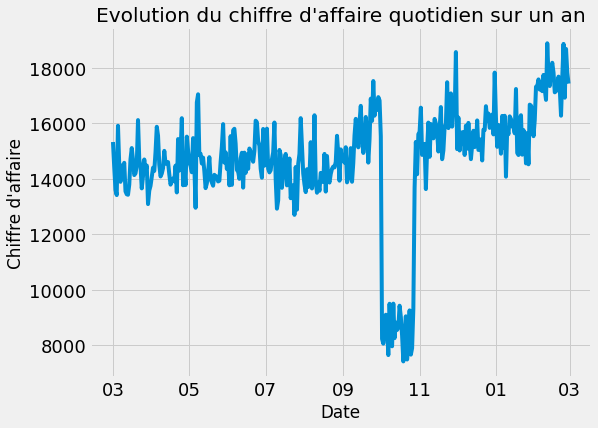

In [64]:
fig = plt.figure()
ax = plt.axes()
x = ca_journalier.price
plt.title("Evolution du chiffre d'affaire quotidien sur un an")
plt.ylabel("Chiffre d'affaire")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
plt.xlabel("Date")
ax.plot(x)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

### Reset des index

In [65]:
ca_journalier = ca_journalier.reset_index()
ca_journalier = ca_journalier.set_index(ca_journalier['date'])

### Zoom sur la période d'octobre

In [66]:
ca_mois_octobre = ca_journalier.loc['2021-10-01':'2021-10-31']

### Affichage Graphique du C.A sur la période d'octobre

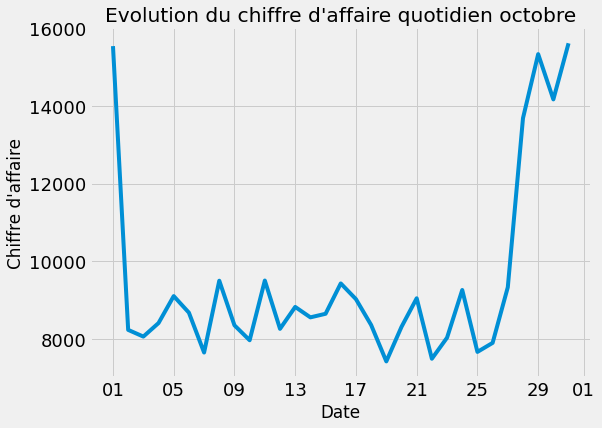

In [67]:
fig = plt.figure()
ax = plt.axes()
x = ca_mois_octobre.price
plt.title("Evolution du chiffre d'affaire quotidien octobre")
plt.ylabel("Chiffre d'affaire")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.xlabel("Date")
ax.plot(x)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

#### Obversation d'une chute anormale entre le 02/10 - 27/10

### Initialisation merge Categ

In [68]:
categ = produits[["id_prod","categ"]]

In [69]:
df = pd.merge(df,categ,left_on="id_prod",right_on="id_prod")

#### Merge Df/Categ sur "id_prod"

### Set index date

In [70]:
df = df.set_index(df['date'])

In [71]:
df_octobre = df.loc['2021-10-02':'2021-10-27']
df_octobre.head(10)

,client_id,id_prod,date,session_id,jour,price,sex,age,mois,categ
date,,,,,,,,,,
2021-10-26,c_5845,2_39,2021-10-26,s_110356,Tuesday,57.99,f,20,10,2
2021-10-21,c_3738,2_39,2021-10-21,s_108095,Thursday,57.99,m,18,10,2
2021-10-18,c_3345,2_39,2021-10-18,s_106813,Monday,57.99,f,20,10,2
2021-10-22,c_3011,2_39,2021-10-22,s_108413,Friday,57.99,m,24,10,2
2021-10-21,c_2593,2_39,2021-10-21,s_107997,Thursday,57.99,m,22,10,2
2021-10-25,c_2540,2_39,2021-10-25,s_110039,Monday,57.99,f,16,10,2
2021-10-24,c_4658,2_39,2021-10-24,s_109218,Sunday,57.99,m,22,10,2
2021-10-15,c_3835,2_39,2021-10-15,s_105282,Friday,57.99,f,24,10,2
2021-10-23,c_3666,2_39,2021-10-23,s_108719,Saturday,57.99,m,22,10,2


#### Création d'une variable contenant les données de la période d'octobre

### Affichage Camembert répartition C.A selon les catégories produit de la période d'octobre

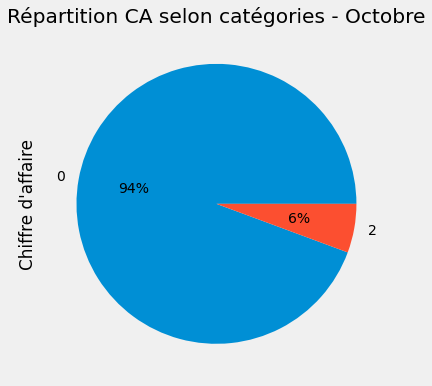

In [72]:
df_octobre['categ'].value_counts(normalize=True).plot(kind='pie', autopct='%1.0f%%')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.ylabel("")
plt.title("Répartition CA selon catégories - Octobre")
plt.ylabel("Chiffre d'affaire")
plt.show()

#### Nous observons la disparitions intégrale de la categorie 1

### Affichage Camembert répartition C.A selon les catégories annuellement 

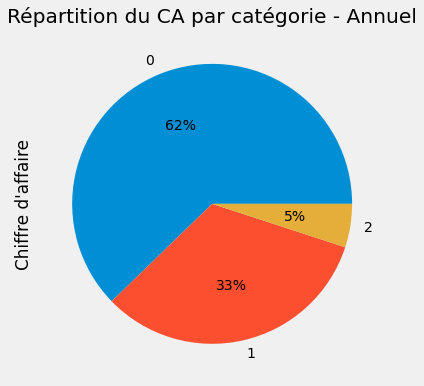

In [73]:
df['categ'].value_counts(normalize=True).plot(kind='pie', autopct='%1.0f%%')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.ylabel("")
plt.title("Répartition du CA par catégorie - Annuel")
plt.ylabel("Chiffre d'affaire")
plt.show()

#### Nous observons que la catégorie 1 représente 33% du C.A annuel

### Nombre de produit dans les catégories

In [74]:
produits.categ.value_counts()

0    2309
1     739
2     239
Name: categ, dtype: int64

#### 739 produits dans la catégorie 1

##### Peut on conclure qu'il y a eu un problème dans la base de donnée ou que c'est une action commerciale ? 

### Doute ? Retrait de la période d'octobre en utilisant un mask

In [75]:
debut_date = '2021-10-01'
fin_date = '2021-10-31'

In [76]:
mask = (df['date'] < debut_date) | (df['date'] > fin_date)

In [77]:
df = df.loc[mask]

### DF mise à jour

In [78]:
df

,client_id,id_prod,date,session_id,jour,price,sex,age,mois,categ
date,,,,,,,,,,
2021-11-21,c_5828,2_99,2021-11-21,s_122697,Sunday,84.99,f,22,11,2
2021-07-11,c_7135,2_99,2021-07-11,s_61009,Sunday,84.99,m,24,7,2
2022-01-22,c_5828,2_39,2022-01-22,s_153560,Saturday,57.99,f,22,1,2
2021-04-21,c_5899,2_39,2021-04-21,s_23479,Wednesday,57.99,m,24,4,2
2021-06-11,c_5467,2_39,2021-06-11,s_47180,Friday,57.99,f,28,6,2
...,...,...,...,...,...,...,...,...,...,...
2022-01-07,c_4396,0_820,2022-01-07,s_146469,Friday,1.32,f,43,1,0
2021-09-16,c_2084,0_820,2021-09-16,s_90543,Thursday,1.32,f,48,9,0
2021-05-11,c_5492,0_820,2021-05-11,s_33114,Tuesday,1.32,f,34,5,0


In [79]:
df[["price","mois"]].sort_values(by=["date","mois"], ascending=True)

,price,mois
date,,
2021-03-01,57.99,3
2021-03-01,16.95,3
2021-03-01,24.47,3
2021-03-01,24.99,3
2021-03-01,27.46,3
...,...,...
2022-02-28,5.99,2
2022-02-28,2.99,2
2022-02-28,22.08,2


In [80]:
df[["price","jour"]].sort_values(by=["date","jour"], ascending = True)

,price,jour
date,,
2021-03-01,57.99,Monday
2021-03-01,16.95,Monday
2021-03-01,24.47,Monday
2021-03-01,24.99,Monday
2021-03-01,27.46,Monday
...,...,...
2022-02-28,5.99,Monday
2022-02-28,2.99,Monday
2022-02-28,22.08,Monday


In [81]:
ca_journalier = df[["price","date"]]
ca_journalier.reset_index(inplace = True, drop = True)
ca_journalier = ca_journalier.groupby(["date"]).sum()

In [82]:
ca_journalier

,price
date,
2021-03-01,15331.37
2021-03-02,14421.19
2021-03-03,13602.03
2021-03-04,13418.64
2021-03-05,15918.13
...,...
2022-02-24,18869.64
2022-02-25,16930.14
2022-02-26,18687.12


### Affichage Graphique C.A journalier sur l'annee, mise à jour (periode octobre supprimee)

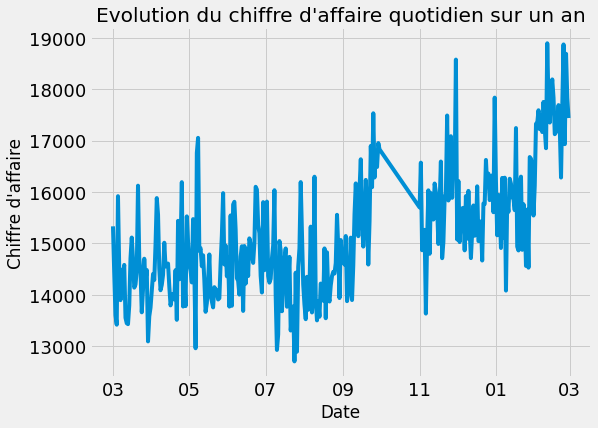

In [83]:
fig = plt.figure()
ax = plt.axes()
x = ca_journalier.price
plt.title("Evolution du chiffre d'affaire quotidien sur un an")
plt.ylabel("Chiffre d'affaire")
plt.xlabel("Date")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.plot(x)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

In [84]:
df

,client_id,id_prod,date,session_id,jour,price,sex,age,mois,categ
date,,,,,,,,,,
2021-11-21,c_5828,2_99,2021-11-21,s_122697,Sunday,84.99,f,22,11,2
2021-07-11,c_7135,2_99,2021-07-11,s_61009,Sunday,84.99,m,24,7,2
2022-01-22,c_5828,2_39,2022-01-22,s_153560,Saturday,57.99,f,22,1,2
2021-04-21,c_5899,2_39,2021-04-21,s_23479,Wednesday,57.99,m,24,4,2
2021-06-11,c_5467,2_39,2021-06-11,s_47180,Friday,57.99,f,28,6,2
...,...,...,...,...,...,...,...,...,...,...
2022-01-07,c_4396,0_820,2022-01-07,s_146469,Friday,1.32,f,43,1,0
2021-09-16,c_2084,0_820,2021-09-16,s_90543,Thursday,1.32,f,48,9,0
2021-05-11,c_5492,0_820,2021-05-11,s_33114,Tuesday,1.32,f,34,5,0


### Calcul du C.A mensuel

In [85]:
ca_mensuel = df[["price","mois"]]
ca_mensuel = ca_mensuel.groupby(["mois"]).sum()
ca_mensuel = ca_mensuel.reset_index()
ca_mensuel['mois'] = ca_mensuel['mois'].astype(object)

### Affichage Graphique du C.A mensuel

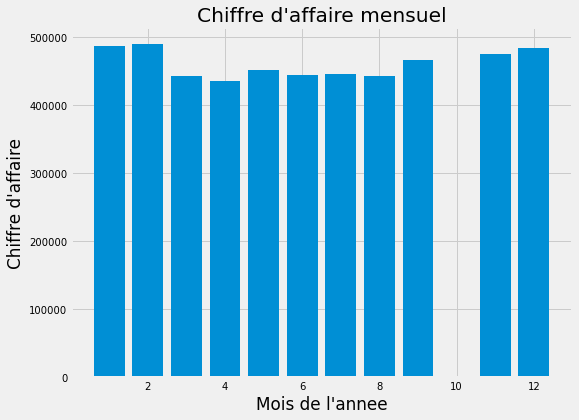

In [86]:
fig = plt.figure()
ax = plt.axes()
y = ca_mensuel.price
x = ca_mensuel.mois
plt.title("Chiffre d'affaire mensuel")
plt.ylabel("Chiffre d'affaire")
plt.xlabel("Mois de l'annee")
ax.bar(x,y)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)

plt.show()

### Calcul du C.A mensuel moyen

In [87]:
ca_mensuel["price"].mean()

460773.7099999131

#### Le C.A mensuel moyen est de 460889 euros

### Calcul du C.A annuel par sex(f/m)

In [88]:
ca_sex = df[['price', 'sex']]

In [89]:
ca_sex = ca_sex.groupby(["sex"]).sum()
ca_sex = ca_sex.reset_index()
ca_sex

,sex,price
0,f,2.635667e+06
1,m,2.432844e+06


### Affichage camembert répartition du C.A annuel selon le sex(f/m) en %

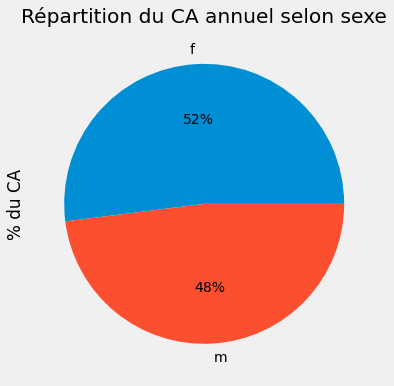

In [90]:
labels = ca_sex.sex
ca_sex['price'].plot(kind='pie', autopct='%1.0f%%',labels=labels)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title("Répartition du CA annuel selon sexe")
plt.ylabel("% du CA")
plt.show()

#### Nous observons que le C.A annuel est établi à 48% par les femme et 52% par les hommes

### Calcul du panier moyen par client

In [91]:
panier = df[["session_id","price"]]
panier = panier.groupby(["session_id"]).sum()

panier = panier.reset_index()
panier.describe()

,price
count,147046.000000
mean,34.468879
std,31.672003
min,0.620000
25%,15.810000
50%,25.990000
75%,43.250000
max,539.230000


#### Nous observons que le panier moyen est de 34 euros / panier médian 26 euros / panier minimum 0.62 ct / panier maximum 539 euros

### Calcul du C.A annuel moyen par client

In [92]:
ca_client = df[["client_id","price"]]
ca_client= ca_client.groupby(["client_id"]).sum()
ca_client = ca_client.reset_index()
ca_client.describe()

,price
count,8594.000000
mean,589.773192
std,432.282395
min,4.150000
25%,260.947500
50%,475.475000
75%,822.177500
max,2436.200000


#### Nous observons que le C.A annuel moyen par client est de 591 euro / médian 476 euros / minnimum 4.15 euros / maximum 2526 euros

# Analyse Clients

### Nombre de clients

In [93]:
len(clients)

8621

#### La base compte 8621 clients

### Affichage graphique de la répartition des clients selon le sex(f/m)

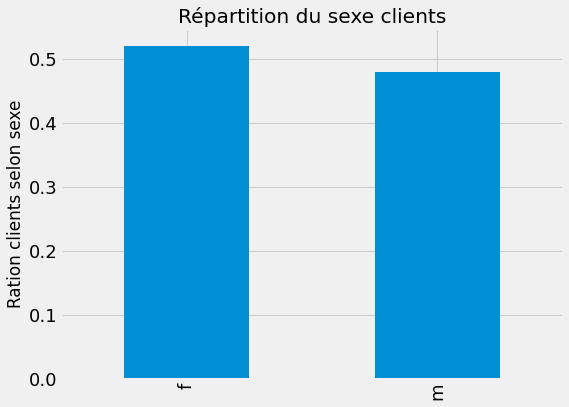

In [94]:
clients['sex'].value_counts(normalize=True).plot(kind='bar')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title("Répartition du sexe clients")
plt.ylabel("Ration clients selon sexe")
plt.show()

### Calcul de la fréquence d'achat client

In [95]:
freq = df[["client_id","session_id"]]
freq['client_id'].value_counts().describe()

count    8594.000000
mean       34.164301
std        31.205225
min         1.000000
25%        13.000000
50%        24.000000
75%        44.000000
max       184.000000
Name: client_id, dtype: float64

#### Nous observons 34 achat en moyen par client / 24 achat médian / 1 achat minimum / 187 achat maximum

### Affichage graphique de la distribution de la fréquence d'achat

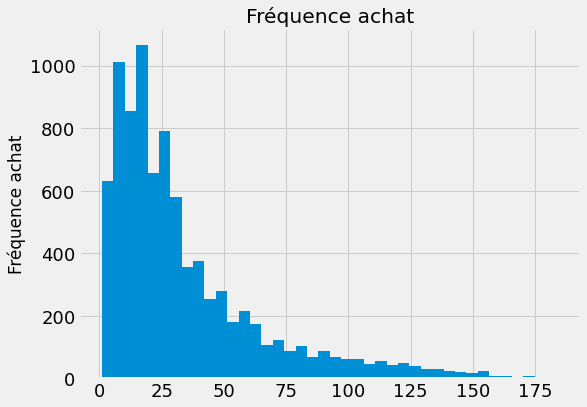

In [96]:
freq['client_id'].value_counts().plot(kind='hist', bins = 40)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title("Fréquence achat")
plt.ylabel("Fréquence achat")
plt.show()

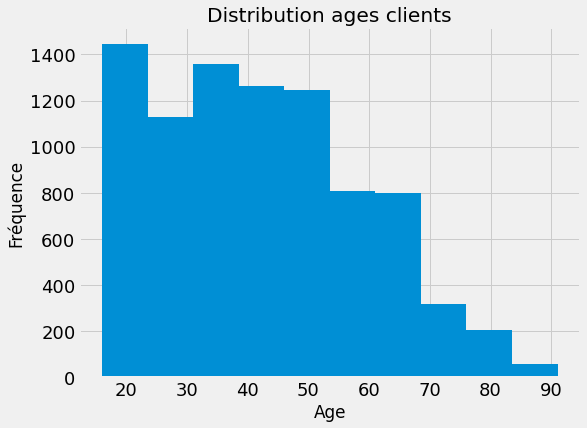

In [97]:
clients['age'].plot(kind='hist')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title("Distribution ages clients")
plt.ylabel("Fréquence")
plt.xlabel("Age")
plt.show()

In [98]:
clients['age'].describe()

count    8621.000000
mean       41.724394
std        16.917958
min        16.000000
25%        28.000000
50%        41.000000
75%        54.000000
max        91.000000
Name: age, dtype: float64

### Affichage graphique relation densité/age client

## Utilisation Indice de GINI

### Concentration Age Client

In [99]:
dep = clients["age"]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

0.23

#### Nous observons que l'indice de gini est de 0.23

### Affichage courbe de Lorenz

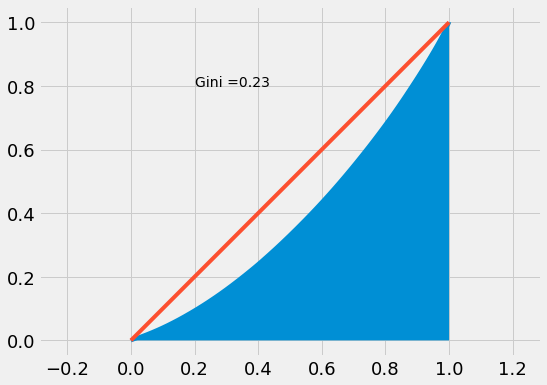

In [100]:
plt.axes().axis('equal')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.show()

### Affichage Graphique de la distribution age des clients selon le sex

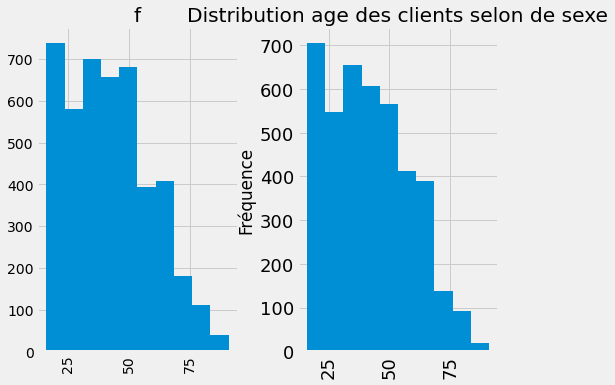

In [101]:
clients['age'].hist(by=clients['sex'])
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title("Distribution age des clients selon de sexe")
plt.ylabel("Fréquence")
plt.show()

#### Nous observons que la distribution est plutôt similaire. Une légère différence f/m pour les personnes de 40-50 ans.

### Calcul montant du panier client selon le sex

In [102]:
session_sex = df[["session_id","sex"]]
panier = pd.merge(session_sex,panier, left_on="session_id", right_on="session_id")

### Affichage graphique du panier moyen selon sex(f/m) - boxplot

Text(0, 0.5, '')

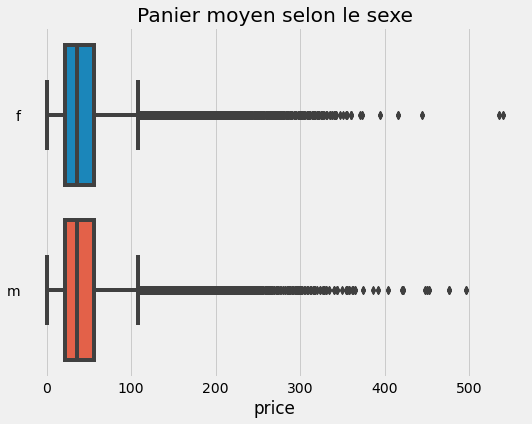

In [103]:
sns.boxplot(y=panier["sex"], x=panier["price"])
plt.title("Panier moyen selon le sexe")
plt.ylabel("Montant du panier")
plt.ylabel("")

# Analyse Produits

In [104]:
len(produits)

3287

#### 3288 produits sont référencés

### Tendance centrale des prix

In [105]:
produits['price'].describe()

count    3287.000000
mean       21.860505
std        29.845770
min         0.620000
25%         6.990000
50%        13.060000
75%        22.990000
max       300.000000
Name: price, dtype: float64

#### Moyenne des prix produit 22 euros / Prix médian 13 euros / minimum 0.62 ct / maximum 300 euros

### Affichage graphique de la distribution des prix produit

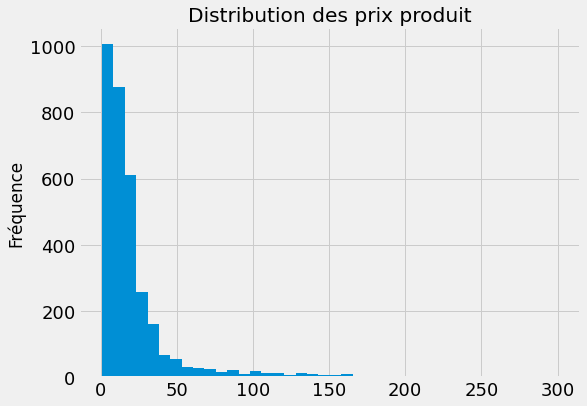

In [106]:
produits['price'].hist(bins=40)
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title("Distribution des prix produit")
plt.ylabel("Fréquence")
plt.show()

### Calcul concentration des prix (GINI)

In [107]:
dep = produits["price"]
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = round(2*S,2)
gini

0.53

#### Nous observons que l'incident de gini est de 0.53

### Affichage graphique de la concentration des prix (courbe de lorenz)

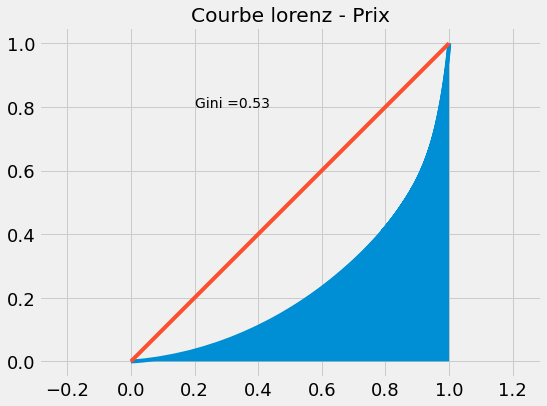

In [108]:
plt.axes().axis('equal')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz)), lorenz)
plt.text(0.2,0.8,"Gini ="+ str(gini))
plt.title("Courbe lorenz - Prix")
plt.show()

### Affichage graphique des prix selon les catégories - boxplot

Text(0, 0.5, 'Prix')

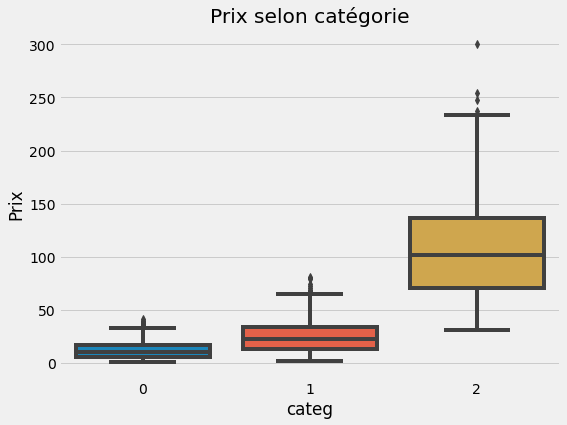

In [109]:
sns.boxplot( x=produits["categ"], y=produits["price"] )
plt.title("Prix selon catégorie")
plt.ylabel("Prix")

### Affichage graphique de la distribution des prix par catégorie

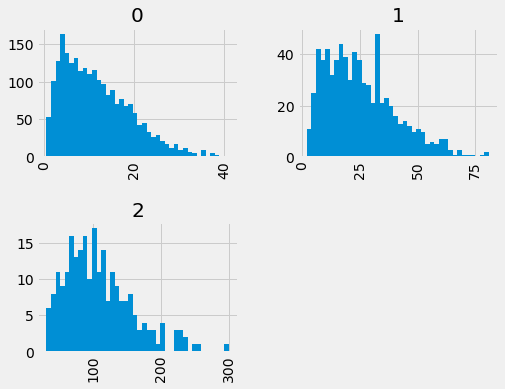

In [110]:
produits['price'].hist(bins=40, by=produits["categ"])
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.title("Distribution des prix par catégorie")
plt.ylabel("Fréquence")
plt.show()

##### Nous allons calculer l'indice de GINI de la concentration des prix pour chaque catégorie et afficher leur courbe de Lorenz

### Calcul GINI catégorie 0 

In [111]:
produits_0 = produits[produits.categ==0]
dep = produits_0["price"]
n_0 = len(dep)
lorenz_0 = np.cumsum(np.sort(dep)) / dep.sum()
lorenz_0 = np.append([0],lorenz_0) # La courbe de Lorenz commence à 0

AUC = (lorenz_0.sum() -lorenz_0[-1]/2 -lorenz_0[0]/2)/n_0 # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini_0 = round(2*S,2)
gini_0

0.36

### Affichage Graphique catégorie 0 (Lorenz)

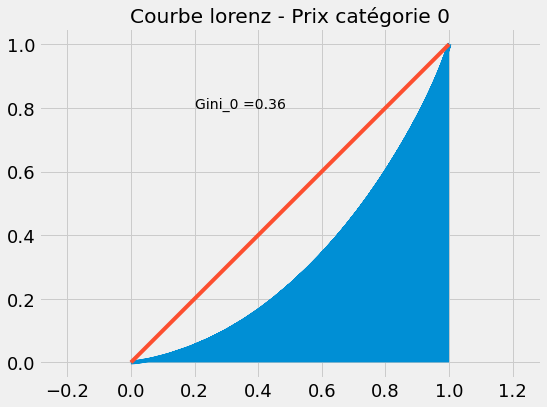

In [112]:
plt.axes().axis('equal')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
xaxis_0 = np.linspace(0-1/n_0,1+1/n_0,n_0+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis_0,lorenz_0,drawstyle='steps-post')
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz_0)), lorenz_0)
plt.text(0.2,0.8,"Gini_0 ="+ str(gini_0))
plt.title("Courbe lorenz - Prix catégorie 0")
plt.show()

### Calcul GINI catégorie 1

In [113]:
produits_1 = produits[produits.categ==1]
dep = produits_1["price"]
n_1 = len(dep)
lorenz_1 = np.cumsum(np.sort(dep)) / dep.sum()
lorenz_1 = np.append([0],lorenz_1) # La courbe de Lorenz commence à 0

AUC = (lorenz_1.sum() -lorenz_1[-1]/2 -lorenz_1[0]/2)/n_1 # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini_1 = round(2*S,2)
gini_1

0.34

### Affichage Graphique catégorie 1 (Lorenz)

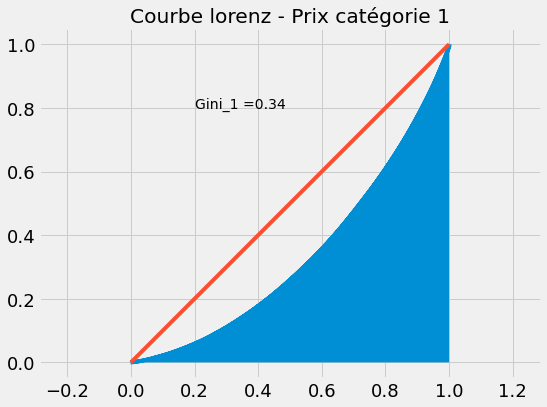

In [114]:
plt.axes().axis('equal')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
xaxis_1 = np.linspace(0-1/n_1,1+1/n_1,n_1+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis_1,lorenz_1,drawstyle='steps-post')
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz_1)), lorenz_1)
plt.text(0.2,0.8,"Gini_1 ="+ str(gini_1))
plt.title("Courbe lorenz - Prix catégorie 1")
plt.show()

### Calcul GINI catégorie 2

In [115]:
produits_2 = produits[produits.categ==2]
dep = produits_2["price"]
n_2 = len(dep)
lorenz_2 = np.cumsum(np.sort(dep)) / dep.sum()
lorenz_2 = np.append([0],lorenz_2) # La courbe de Lorenz commence à 0

AUC = (lorenz_2.sum() -lorenz_2[-1]/2 -lorenz_2[0]/2)/n_2 # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini_2 = round(2*S,2)
gini_2

0.25

### Affichage Graphique catégorie 1 (Lorenz)

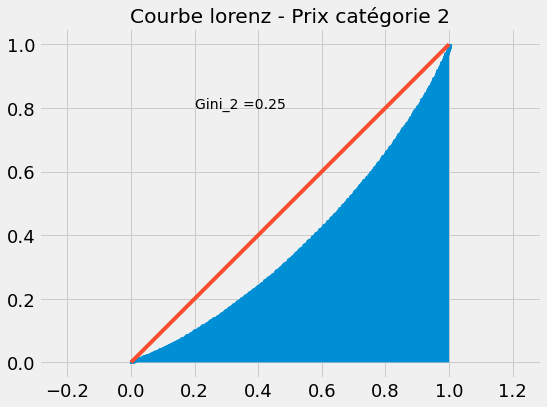

In [116]:
plt.axes().axis('equal')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
xaxis_2 = np.linspace(0-1/n_2,1+1/n_2,n_2+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis_2,lorenz_2,drawstyle='steps-post')
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.fill_between(np.linspace(0,1,len(lorenz_2)), lorenz_2)
plt.text(0.2,0.8,"Gini_2 ="+ str(gini_2))
plt.title("Courbe lorenz - Prix catégorie 2")
plt.show()

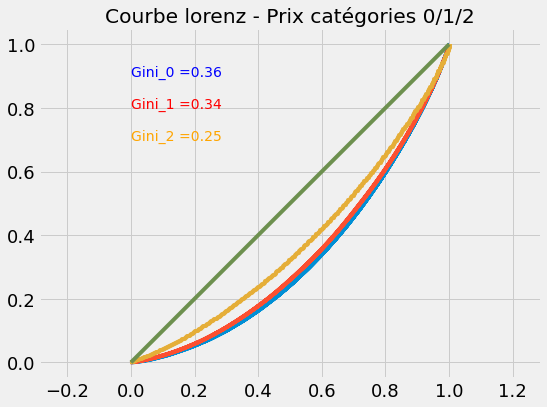

In [117]:
plt.axes().axis('equal')
plt.tick_params(axis = 'both', which = 'major', labelsize = 18)
xaxis_0 = np.linspace(0-1/n_0,1+1/n_0,n_0+1)
xaxis_1 = np.linspace(0-1/n_1,1+1/n_1,n_1+1)
xaxis_2 = np.linspace(0-1/n_2,1+1/n_2,n_2+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis_0,lorenz_0,drawstyle='steps-post')
plt.plot(xaxis_1,lorenz_1,drawstyle='steps-post')
plt.plot(xaxis_2,lorenz_2,drawstyle='steps-post')
ident = [0.0, 1.0]
plt.plot(ident,ident)
plt.text(0.0,0.9,"Gini_0 ="+ str(gini_0), color='blue')
plt.text(0.0,0.8,"Gini_1 ="+ str(gini_1), color='red')
plt.text(0.0,0.7,"Gini_2 ="+ str(gini_2), color='orange')
plt.title("Courbe lorenz - Prix catégories 0/1/2")
plt.show()

### Affichage graphique de la relation "age client" et "prix produits" achetés - régréssion linéaire

Text(0, 0.5, 'Prix')

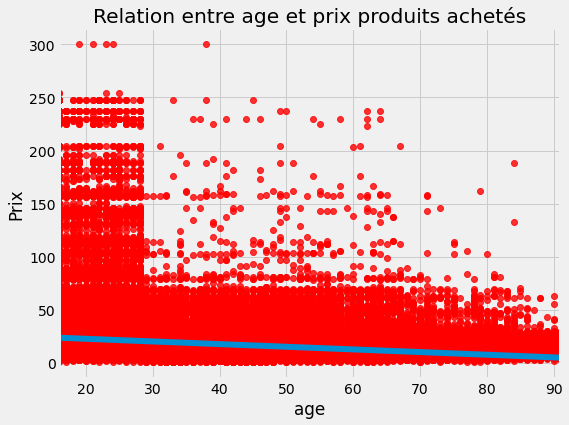

In [118]:
sns.regplot(y=df["price"], x=df["age"],ci = None,scatter_kws = {"color": "red"})
plt.title("Relation entre age et prix produits achetés")
plt.ylabel("Prix")

In [119]:
print(st.spearmanr(df["price"], df["age"])[0])

-0.04617450863453378


### Affichage des 10 produits les plus vendu

In [120]:
df['id_prod'].value_counts().head(10)

1_369    1003
1_417     981
1_414     953
1_498     946
1_425     931
1_413     883
1_398     875
1_412     873
1_406     873
1_407     866
Name: id_prod, dtype: int64

### Affichage tableau de contingence entre sexe et catégories produits achetés - Qualitatif / Qualitatif 

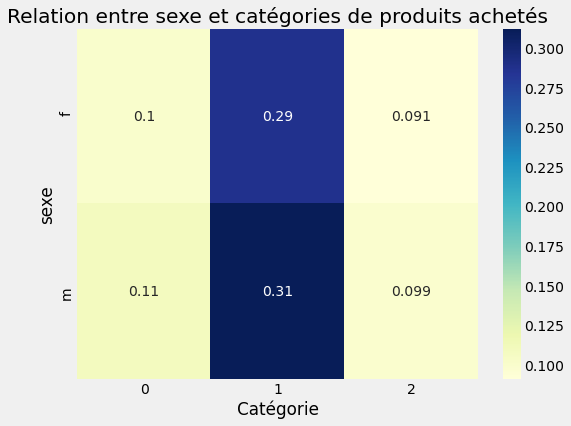

In [121]:
X = "sex"
Y = "categ"

cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(df)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=True,cmap="YlGnBu")
plt.title("Relation entre sexe et catégories de produits achetés")
plt.ylabel("sexe")
plt.xlabel("Catégorie")
plt.show()

In [122]:
chi2_contingency(cont.iloc[:-1, :-1])

(8.965632630745457,
 0.011301539593042658,
 2,
 array([[92620.107572  , 52624.77707011,  7654.11535789],
        [85235.892428  , 48429.22292989,  7043.88464211]]))

In [123]:
cont

categ,0,1,2,Total
sex,,,,
f,92331,52993,7575,152899
m,85525,48061,7123,140709
Total,177856,101054,14698,293608


### Calcul de ETA SQUARED

In [124]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print(eta_squared(df["sex"],df["categ"]))

5.906478553371057e-06


#### Eta² = 5.523225671942628e-06

### Relation age et CA cumulé

In [125]:
ca_age=df[["client_id","price"]]
ca_age=ca_age.groupby(["client_id"]).sum()
ca_age = ca_age.reset_index()

### Création table age

In [126]:
age=clients[["client_id","age"]]

#### Merge

In [127]:
ca_age=pd.merge(ca_age,age,left_on="client_id", right_on="client_id")

### Affichage Graphique de la relation "age" et "CA Cumulé" - Nuage de points - Quantitatif / Quantitatif

Text(0.5, 0, 'Age')

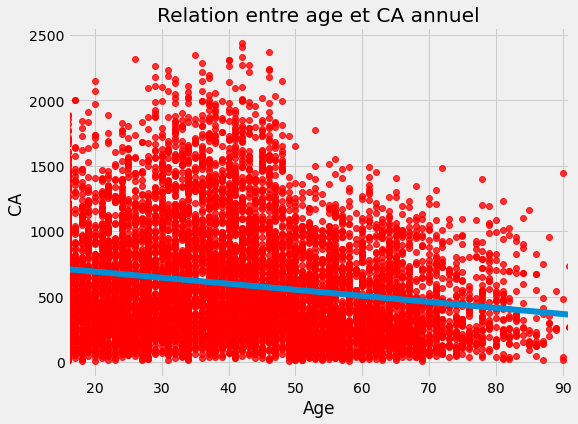

In [128]:
sns.regplot(y=ca_age["price"], x=ca_age["age"],ci = None,scatter_kws = {"color": "red"})
plt.title("Relation entre age et CA annuel")
plt.ylabel("CA")
plt.xlabel("Age")

### Calcul coef de Pearson // Spearman et covariance

In [129]:
print("coef de pearson: ", st.pearsonr(ca_age["price"], ca_age["age"])[0])
print("coef de spearman: ", st.spearmanr(ca_age["price"], ca_age["age"])[0])
print("covariance: ", np.cov(ca_age["price"], ca_age["age"],ddof=0)[1,0])

coef de pearson:  -0.1810203613882887
coef de spearman:  -0.1811562153503065
covariance:  -1323.2102241578555


#### Coef de Pearson (p) = -0.1805199609683848 // Coef de Spearman = -0.1806939509979426

### Calcul du CA par décénie

In [130]:
ca_age["diz"]=round(ca_age.age,-1)

In [131]:
ca_age = ca_age.groupby(["diz"]).sum()
ca_age = ca_age.reset_index()

In [132]:
ca_age

,diz,price,age
0,20,1086764.37,35638
1,30,1010757.43,45474
2,40,1363324.79,75782
3,50,719083.93,68363
4,60,547586.58,73050
5,70,215227.97,36387
6,80,112111.34,20688
7,90,13654.40,3331


### Affichage grapgique de la relation entre "CA cumulé" et "décénie" - Régréssion Linéaire - Quantitatif / Qualitatif

Text(0.5, 0, 'Décennie')

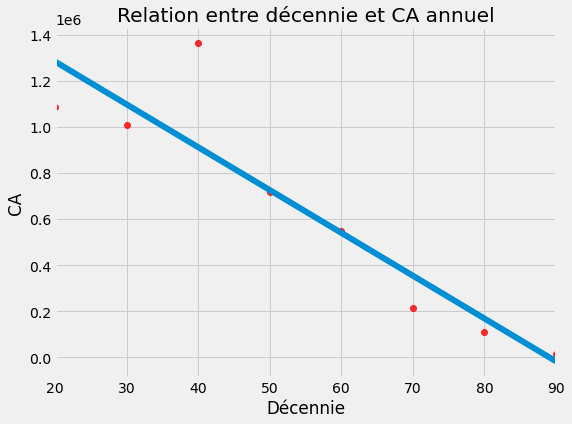

In [133]:
sns.regplot(y=ca_age["price"], x=ca_age["diz"],ci = None,scatter_kws = {"color": "red"})
plt.title("Relation entre décennie et CA annuel")
plt.ylabel("CA")
plt.xlabel("Décennie")

### Calcul coef de Pearson et Covariance

In [134]:
print(st.pearsonr(ca_age["price"], ca_age["diz"])[0])
print(np.cov(ca_age["price"], ca_age["diz"],ddof=0)[1,0])

-0.917300894086478
-9762992.531249998


#### Coef de Pearson (p) = -0.9165751521900272

### Calcul de la fréquence d'achat client

In [135]:
freq = pd.crosstab(index = df["client_id"], columns="count")
freq = pd.merge(freq,age,left_on="client_id", right_on="client_id")

### Affichage graphique de la relation "age" et "fréquence d'achat"  - Nuage de points - Quantitatif / Quantitatif

Text(0.5, 0, 'Age')

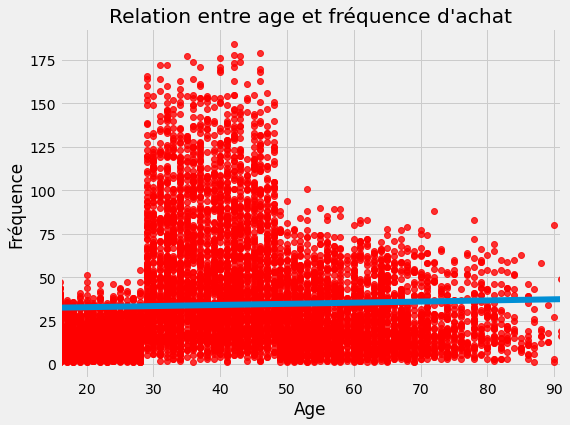

In [136]:
sns.regplot(y=freq["count"], x=freq["age"],ci = None,scatter_kws = {"color": "red"})
plt.title("Relation entre age et fréquence d'achat")
plt.ylabel("Fréquence")
plt.xlabel("Age")

### Calcul des fréquences d'achat par décénie d'age client

In [137]:
freq["diz"]=round(freq.age,-1)
freq = freq.groupby(["diz"]).sum()
freq = freq.reset_index()

In [138]:
freq

,diz,count,age
0,20,27239,35638
1,30,62322,45474
2,40,103077,75782
3,50,47937,68363
4,60,32597,73050
5,70,12943,36387
6,80,6671,20688
7,90,822,3331


### Affichage graphique de la relation entre les "décénies" et la "fréquence d'achat"  - Regression Linéaire- Quantitatif / Qualitatif

Text(0.5, 0, 'Décennie')

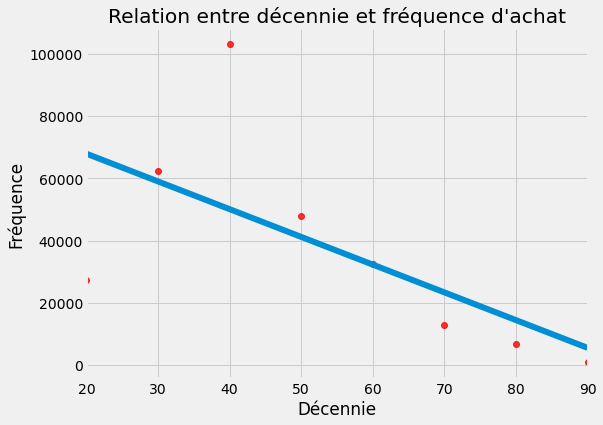

In [139]:
sns.regplot(y=freq["count"], x=freq["diz"],ci = None,scatter_kws = {"color": "red"})
plt.title("Relation entre décennie et fréquence d'achat")
plt.ylabel("Fréquence")
plt.xlabel("Décennie")

### Merge Relation age et panier moyen

In [140]:
session_age = df[["session_id","age"]]
session_age = session_age.reset_index()
del session_age['date']
session_age.head(5)

,session_id,age
0,s_122697,22
1,s_61009,24
2,s_153560,22
3,s_23479,24
4,s_47180,28


In [141]:
session_age = pd.merge(session_age,panier, left_on="session_id", right_on="session_id")
session_age = session_age.reset_index()

In [142]:
session_age

,index,session_id,age,sex,price
0,0,s_122697,22,f,84.99
1,1,s_61009,24,m,84.99
2,2,s_153560,22,f,57.99
3,3,s_23479,24,m,57.99
4,4,s_47180,28,f,57.99
...,...,...,...,...,...
827285,827285,s_146634,62,m,0.99
827286,827286,s_133147,79,f,11.99
827287,827287,s_65327,46,f,1.83
827288,827288,s_159963,40,m,20.02


### Affichage Graphique de la relation "age" et du "panier moyen" - Nuage de points - Quantitatif / Quantitatif

Text(0.5, 0, 'Panier moyen')

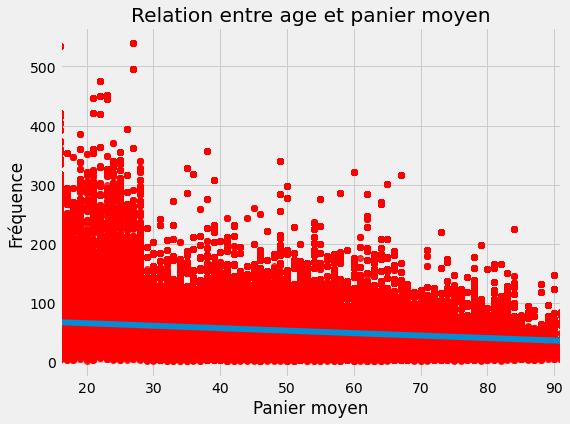

In [143]:
sns.regplot(y=session_age["price"], x=session_age["age"],ci = None,scatter_kws = {"color": "red"})
plt.title("Relation entre age et panier moyen")
plt.ylabel("Fréquence")
plt.xlabel("Panier moyen")

### Calcul des décénies

In [144]:
session_age["diz"]=round(session_age.age,-1)
session_age = session_age.groupby(["diz"]).sum()
session_age = session_age.reset_index()

### Afichage Graphique de la relation entre les "décénies d'age" client et le "panier moyen" client - Regression Lineaire - Quantitatif / Qualitatif 

Text(0.5, 0, 'Décennie')

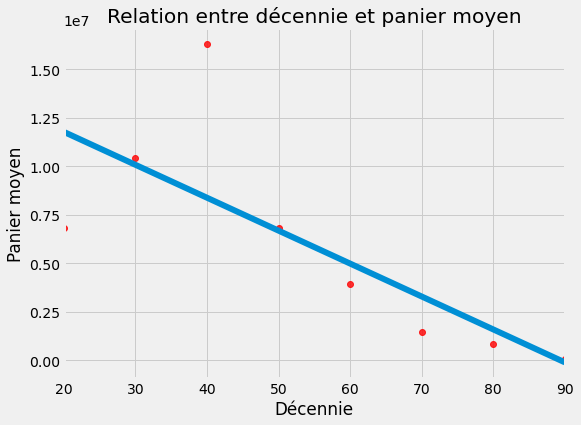

In [145]:
sns.regplot(y=session_age["price"], x=session_age["diz"],ci = None,scatter_kws = {"color": "red"})
plt.title("Relation entre décennie et panier moyen")
plt.ylabel("Panier moyen")
plt.xlabel("Décennie")

In [146]:
df["diz"]=round(df.age,-1)

### Tableau de contingence Décénies / Catégories - Qualitatif / Qualitatif

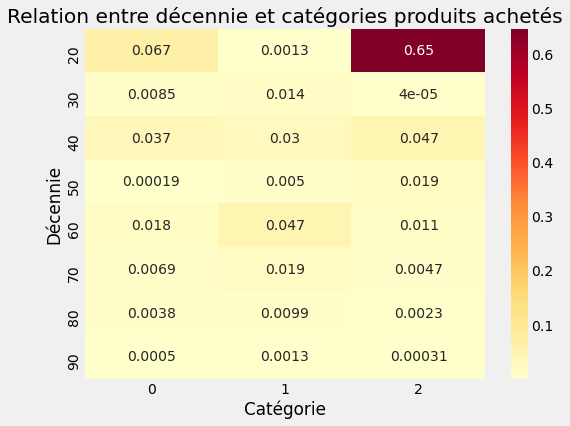

In [147]:
X = "diz"
Y = "categ"

cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(df)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=True,cmap="YlOrRd")
plt.title("Relation entre décennie et catégories produits achetés")
plt.ylabel("Décennie")
plt.xlabel("Catégorie")
plt.show()

### BoxPlot - Relation Age / Categories - Quantitatif / Qualitatif

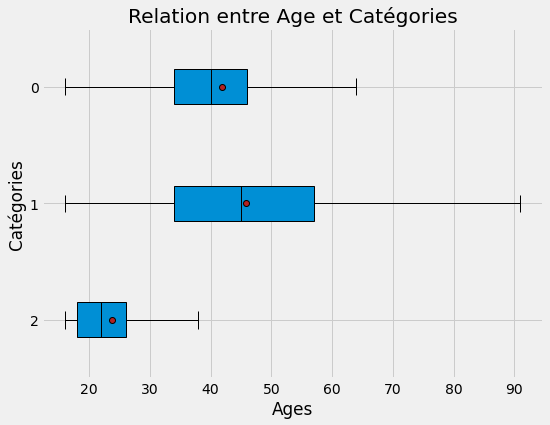

In [148]:
X = "categ"
Y = "age"

sous_echantillon = df[['age', 'categ']]

categories = sous_echantillon[X].unique()
groupes = []
for m in categories:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriétés graphiques
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=categories, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("Relation entre Age et Catégories")
plt.ylabel("Catégories")
plt.xlabel("Ages")
plt.show()

#### Calcul Eta²

In [149]:
eta_squared(df["age"],df["categ"])

0.2628332501175262

### Création d'un mask groupe_age pour préparer tableau contingence

In [150]:
mask = df['age'] < 30
df.loc[mask, 'groupe_age'] = "Groupe 1"
mask = (df['age'] < 50) & (df['age'] >= 30)
df.loc[mask, 'groupe_age'] = "Groupe 2"
mask = df['age'] >= 50
df.loc[mask, 'groupe_age'] = "Groupe 3"

df['groupe_age'] = df['groupe_age'].astype('category')

### Tableau de contingence - Groupe Age / Categories Produits - Qualitatif / Qualitatif

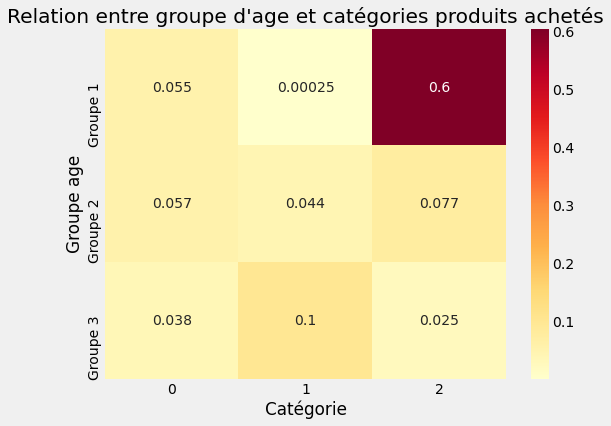

In [151]:
X = "groupe_age"
Y = "categ"

cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(df)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=True,cmap="YlOrRd")
plt.title("Relation entre groupe d'age et catégories produits achetés")
plt.ylabel("Groupe age")
plt.xlabel("Catégorie")
plt.show()

#### Calcul Eta²

In [152]:
eta_squared(df["groupe_age"],df["categ"])

0.20361805319470433

In [153]:
chi2_contingency(cont.iloc[:-1, :-1])

(102633.4468986151,
 0.0,
 4,
 array([[ 25559.44001526,  14522.33071306,   2112.22927168],
        [108287.48579058,  61526.64846326,   8948.86574616],
        [ 44009.07419416,  25005.02082368,   3636.90498215]]))